In [1]:
import pandas as pd
import numpy as np

# Initial data exploration

In [2]:
source1 = pd.read_csv('data/source1.csv')
source2 = pd.read_csv('data/source2.csv')

In [3]:
source1

,First Name,Last Name,Date of Birth,Address,Nationality
0,Joseph,Mueller,2 Jan 1989,Friedrichstrasse 76 10117 Berlin,Germany
1,Josef,Müller,1 Feb 1989,10117 Friedrichstraße,NL
2,John,Doe,NaN,Walachei 112,
3,Bob,Ross,29 Oct 1942,123 Main Street,US


In [4]:
source1.dtypes

First Name       object
Last Name        object
Date of Birth    object
Address          object
Nationality      object
dtype: object

In [5]:
source2

,first_name,last_name,birth_date,address,country,phone
0,Joseph,Müller,01.02.1989,2 Kehrwieder 20457,DE,NaN
1,Katarina,Mueller,01.01.1970,10117 Friedrichstrasse 78,DEU,NaN
2,BOB,ROSS,06.02.1945,,US,NaN
3,J,MULLER,2.1.1989,NaN,DE,NaN


# Aggregate

### Common schema

In [6]:
columns = ['first_name', 'last_name', 'date_of_birth', 'address', 'nationality']

source2 = source2.drop(columns=['phone'])

source1.columns = columns
source2.columns = columns

In [7]:
source1

,first_name,last_name,date_of_birth,address,nationality
0,Joseph,Mueller,2 Jan 1989,Friedrichstrasse 76 10117 Berlin,Germany
1,Josef,Müller,1 Feb 1989,10117 Friedrichstraße,NL
2,John,Doe,NaN,Walachei 112,
3,Bob,Ross,29 Oct 1942,123 Main Street,US


In [8]:
source2

,first_name,last_name,date_of_birth,address,nationality
0,Joseph,Müller,01.02.1989,2 Kehrwieder 20457,DE
1,Katarina,Mueller,01.01.1970,10117 Friedrichstrasse 78,DEU
2,BOB,ROSS,06.02.1945,,US
3,J,MULLER,2.1.1989,NaN,DE


In [9]:
source1['date_of_birth'] = pd.to_datetime(source1['date_of_birth'], format='%d %b %Y')
source1

,first_name,last_name,date_of_birth,address,nationality
0,Joseph,Mueller,1989-01-02,Friedrichstrasse 76 10117 Berlin,Germany
1,Josef,Müller,1989-02-01,10117 Friedrichstraße,NL
2,John,Doe,NaT,Walachei 112,
3,Bob,Ross,1942-10-29,123 Main Street,US


In [10]:
source1.dtypes

first_name               object
last_name                object
date_of_birth    datetime64[ns]
address                  object
nationality              object
dtype: object

In [11]:
source2['date_of_birth'] = pd.to_datetime(source2['date_of_birth'], format='%d.%m.%Y')

### One dataset

In [12]:
source1['source'] = 'source1'
source2['source'] = 'source2'

df = (
    pd.concat([source1, source2])
    .reset_index()
    .drop(columns=['index'])
)

In [13]:
def highlight_sources(row):
    return ['background-color: lightcyan' if row['source'] == 'source1' else 'background-color: lightblue' for col in row]

def pretty_print_sources(df):
    return df.style.apply(highlight_sources, axis=1)

pretty_print_sources(df)

,first_name,last_name,date_of_birth,address,nationality,source
0,Joseph,Mueller,1989-01-02 00:00:00,Friedrichstrasse 76 10117 Berlin,Germany,source1
1,Josef,Müller,1989-02-01 00:00:00,10117 Friedrichstraße,NL,source1
2,John,Doe,NaT,Walachei 112,,source1
3,Bob,Ross,1942-10-29 00:00:00,123 Main Street,US,source1
4,Joseph,Müller,1989-02-01 00:00:00,2 Kehrwieder 20457,DE,source2
5,Katarina,Mueller,1970-01-01 00:00:00,10117 Friedrichstrasse 78,DEU,source2
6,BOB,ROSS,1945-02-06 00:00:00,,US,source2
7,J,MULLER,1989-01-02 00:00:00,nan,DE,source2


# Preprocessing

In [14]:
df = df.replace(r'^\s*$', np.nan, regex=True)
pretty_print_sources(df)

,first_name,last_name,date_of_birth,address,nationality,source
0,Joseph,Mueller,1989-01-02 00:00:00,Friedrichstrasse 76 10117 Berlin,Germany,source1
1,Josef,Müller,1989-02-01 00:00:00,10117 Friedrichstraße,NL,source1
2,John,Doe,NaT,Walachei 112,nan,source1
3,Bob,Ross,1942-10-29 00:00:00,123 Main Street,US,source1
4,Joseph,Müller,1989-02-01 00:00:00,2 Kehrwieder 20457,DE,source2
5,Katarina,Mueller,1970-01-01 00:00:00,10117 Friedrichstrasse 78,DEU,source2
6,BOB,ROSS,1945-02-06 00:00:00,nan,US,source2
7,J,MULLER,1989-01-02 00:00:00,nan,DE,source2


In [15]:
import pycountry

In [16]:
mask = df['nationality'].notna()
df.loc[mask, 'nationality'] = df[mask]['nationality'].apply(lambda x: pycountry.countries.lookup(x).alpha_2)
pretty_print_sources(df)

,first_name,last_name,date_of_birth,address,nationality,source
0,Joseph,Mueller,1989-01-02 00:00:00,Friedrichstrasse 76 10117 Berlin,DE,source1
1,Josef,Müller,1989-02-01 00:00:00,10117 Friedrichstraße,NL,source1
2,John,Doe,NaT,Walachei 112,nan,source1
3,Bob,Ross,1942-10-29 00:00:00,123 Main Street,US,source1
4,Joseph,Müller,1989-02-01 00:00:00,2 Kehrwieder 20457,DE,source2
5,Katarina,Mueller,1970-01-01 00:00:00,10117 Friedrichstrasse 78,DE,source2
6,BOB,ROSS,1945-02-06 00:00:00,nan,US,source2
7,J,MULLER,1989-01-02 00:00:00,nan,DE,source2


In [17]:
groups = df['address'].str.extract(r'(.*)(\d{5})(.*)')
groups['address'] = groups[0].str.strip() + ' ' + groups[2].str.strip()
groups['post_code'] = groups[1]
mask = ~groups.isnull().all(axis=1)
df['post_code'] = np.nan
df.loc[mask, ['address', 'post_code']] = groups.loc[mask, ['address', 'post_code']]
pretty_print_sources(df)

,first_name,last_name,date_of_birth,address,nationality,source,post_code
0,Joseph,Mueller,1989-01-02 00:00:00,Friedrichstrasse 76 Berlin,DE,source1,10117
1,Josef,Müller,1989-02-01 00:00:00,Friedrichstraße,NL,source1,10117
2,John,Doe,NaT,Walachei 112,nan,source1,nan
3,Bob,Ross,1942-10-29 00:00:00,123 Main Street,US,source1,nan
4,Joseph,Müller,1989-02-01 00:00:00,2 Kehrwieder,DE,source2,20457
5,Katarina,Mueller,1970-01-01 00:00:00,Friedrichstrasse 78,DE,source2,10117
6,BOB,ROSS,1945-02-06 00:00:00,nan,US,source2,nan
7,J,MULLER,1989-01-02 00:00:00,nan,DE,source2,nan


In [18]:
de_mapping = {'ü': 'ue', 'ä': 'a', 'ö': 'o', 'ß': 'ss'}
trans_table = ''.join(de_mapping.keys()).maketrans(de_mapping)

for column in ['first_name', 'last_name', 'address']:
    df[column] = df[column].str.lower()
    df[column] = df[column].str.translate(trans_table)
    
pretty_print_sources(df)

,first_name,last_name,date_of_birth,address,nationality,source,post_code
0,joseph,mueller,1989-01-02 00:00:00,friedrichstrasse 76 berlin,DE,source1,10117
1,josef,mueller,1989-02-01 00:00:00,friedrichstrasse,NL,source1,10117
2,john,doe,NaT,walachei 112,nan,source1,nan
3,bob,ross,1942-10-29 00:00:00,123 main street,US,source1,nan
4,joseph,mueller,1989-02-01 00:00:00,2 kehrwieder,DE,source2,20457
5,katarina,mueller,1970-01-01 00:00:00,friedrichstrasse 78,DE,source2,10117
6,bob,ross,1945-02-06 00:00:00,nan,US,source2,nan
7,j,muller,1989-01-02 00:00:00,nan,DE,source2,nan


# Block

In [19]:
import recordlinkage

In [20]:
indexer = recordlinkage.Index()
indexer.add(recordlinkage.index.Block(['last_name', 'date_of_birth']))
indexer.add(recordlinkage.index.Block(['last_name', 'post_code']))
block_mi = indexer.index(df)

In [21]:
def join_with_data(mi, df):
    left_index = mi.get_level_values(0)
    right_index = mi.get_level_values(1)
    left_df = df.loc[left_index].reset_index().add_suffix('__l')
    right_df = df.loc[right_index].reset_index().add_suffix('__r')
    
    return left_df.join(right_df)

def highlight_sources_pairs(row):
    colors = ['background-color: lightcyan', 'background-color: lightblue']
    for i in range(len(row)):
        color1 = colors[0] if row['source__l'] == 'source1' else colors[1]
        color2 = colors[0] if row['source__r'] == 'source1' else colors[1]
        
    return [color1 if row.index[i].endswith('__l') else color2 for i in range(len(row))]

def pretty_print_sources_pairs(df):
    return df.style.apply(highlight_sources_pairs, axis=1)

interesting_columns = ['first_name', 'last_name', 'date_of_birth', 'post_code', 'source']
pretty_print_sources_pairs(join_with_data(block_mi, df[interesting_columns]))

,index__l,first_name__l,last_name__l,date_of_birth__l,post_code__l,source__l,index__r,first_name__r,last_name__r,date_of_birth__r,post_code__r,source__r
0,1,josef,mueller,1989-02-01 00:00:00,10117,source1,0,joseph,mueller,1989-01-02 00:00:00,10117,source1
1,4,joseph,mueller,1989-02-01 00:00:00,20457,source2,1,josef,mueller,1989-02-01 00:00:00,10117,source1
2,5,katarina,mueller,1970-01-01 00:00:00,10117,source2,0,joseph,mueller,1989-01-02 00:00:00,10117,source1
3,5,katarina,mueller,1970-01-01 00:00:00,10117,source2,1,josef,mueller,1989-02-01 00:00:00,10117,source1


In [22]:
from math import factorial

num_combinations = int(factorial(8) / (factorial(2) * factorial(8 - 2)))
num_combinations

28

# Featurize

In [23]:
df['full_name'] = df[['first_name', 'last_name']].agg(' '.join, axis=1)

# define the features
comparator = recordlinkage.Compare()
comparator.exact('date_of_birth', 'date_of_birth', label='exact__dob')
comparator.exact('post_code', 'post_code', label='exact__post_code')
comparator.string('full_name', 'full_name', method='levenshtein', threshold=0.85, label='leven__full_name')

# compute the pairs
features = comparator.compute(block_mi, df).reset_index().drop(columns=['level_0', 'level_1'])

interesting_columns = ['full_name__l', 'full_name__r', 'date_of_birth__l', 'date_of_birth__r',
                       'post_code__l', 'post_code__r',
                       'exact__dob', 'exact__post_code', 'leven__full_name']
df_pairs = join_with_data(block_mi, df).join(features)
df_pairs[interesting_columns]

,full_name__l,full_name__r,date_of_birth__l,date_of_birth__r,post_code__l,post_code__r,exact__dob,exact__post_code,leven__full_name
0,josef mueller,joseph mueller,1989-02-01,1989-01-02,10117,10117,0,1,1.0
1,joseph mueller,josef mueller,1989-02-01,1989-02-01,20457,10117,1,0,1.0
2,katarina mueller,joseph mueller,1970-01-01,1989-01-02,10117,10117,0,1,0.0
3,katarina mueller,josef mueller,1970-01-01,1989-02-01,10117,10117,0,1,0.0


# Classify

In [24]:
# define the rules
rule_1 = ((df_pairs['leven__full_name'] == 1) & (df_pairs['exact__dob'] == 1))
rule_2 = ((df_pairs['leven__full_name'] == 1) & (df_pairs['exact__post_code'] == 1))

# these pairs remain
matches = df_pairs[rule_1 | rule_2]
matches[interesting_columns + ['index__l', 'index__r']]

,full_name__l,full_name__r,date_of_birth__l,date_of_birth__r,post_code__l,post_code__r,exact__dob,exact__post_code,leven__full_name,index__l,index__r
0,josef mueller,joseph mueller,1989-02-01,1989-01-02,10117,10117,0,1,1.0,1,0
1,joseph mueller,josef mueller,1989-02-01,1989-02-01,20457,10117,1,0,1.0,4,1


# Extract Clusters

In [25]:
import networkx as nx

In [26]:
graph = nx.Graph()
graph.add_edges_from(zip(matches['index__l'].values, matches['index__r'].values))
graph.add_nodes_from(df.drop(graph.nodes).index.values)
connected_nodes = list(nx.connected_components(graph))
connected_nodes

[{0, 1, 4}, {2}, {3}, {5}, {6}, {7}]

In [27]:
import matplotlib.pyplot as plt

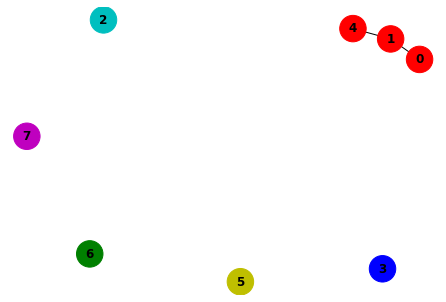

In [28]:
colors = ['r', 'c', 'b', 'y', 'g', 'm']
colors_to_draw = []
for i, cluster in enumerate(connected_nodes):
    for _ in cluster:
        colors_to_draw.append(colors[i])
    
nx.draw(graph, with_labels=True, font_weight='bold', node_size=700, node_color=colors_to_draw)